# Lab 8: matrix equations and linear least-squares fitting

## Matrix operations

We begin today’s lab with a quick investigation of how to use numpy `array`s to represent matrices. We can use the `array` *constructor* function to make a matrix:

In [9]:
import numpy as np

In [10]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
B = np.array([[2,0,0],[0,1,0],[0,0,1]])
print(A)
print(B)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[2 0 0]
 [0 1 0]
 [0 0 1]]


It is tempting to multiply the matrices by using `*`, but if we try:

In [11]:
print(A*B)

[[2 0 0]
 [0 5 0]
 [0 0 9]]


**Can you explain what has happened?** 

The correct way is to use the `dot` function, or to use the shorthand `@`:

In [12]:
print(A@B)

[[ 2  2  3]
 [ 8  5  6]
 [14  8  9]]


In [13]:
print(np.dot(A,B))

[[ 2  2  3]
 [ 8  5  6]
 [14  8  9]]


Numpy is clever enough to interpret a one-dimensional array as either a row or a column matrix depending on the context:

In [14]:
v = np.array([1,0,0])
print(A@v)
print(v@A)

[1 4 7]
[1 2 3]


Many useful matrix manipulation tools are in the `linalg` namespace. Among these, we can find the inverse of a matrix with `inv`:

In [15]:
np.linalg.inv(B)

array([[ 0.5,  0. ,  0. ],
       [ 0. ,  1. ,  0. ],
       [ 0. ,  0. ,  1. ]])

(Note as always that we can `import` functions directly into the main namespace if this is too much typing, by evaluating `from numpy.linalg import inv` or whatever.)

Let’s put this to use by solving a matrix equation. Specifically, let’s solve the simultaneous equations
$$\begin{align*}
2x + 3y &= 16 \\
7x - 2y &= 31 \\
\end{align*}
$$
or, equivalently,
$$
\begin{pmatrix}2 & 3 \\ 7 & -2\end{pmatrix}
\begin{pmatrix}x \\y \end{pmatrix} =
\begin{pmatrix}16 \\ 31\end{pmatrix}.
$$

The obvious way is to use the matrix inverse:
$$
\begin{pmatrix}x \\y \end{pmatrix} =
\begin{pmatrix}2 & 3 \\ 7 & -2\end{pmatrix}^{-1}
\begin{pmatrix}16 \\ 31\end{pmatrix}.
$$
**Use the matrix commands we’ve just learned to evaluate the RHS of this equation.**

In [16]:
A=np.array([[2,3],[7,-2]])
b=np.array([[16],[31]])
A1=np.linalg.inv(A)
print(A1@b)

[[ 5.]
 [ 2.]]


### Another option is to use the `linalg.solve` function, which exists specifically to solve matrix equations of the form $\mathbf{Ax} = \mathbf{b}$. It takes two arguments, the matrix $\mathbf{A}$ and the vector $\mathbf{b}$. **Check that you get the same answer using this method:**

In [17]:
# Define suitable A and b here
A=np.array([[2,3],[7,-2]])
b=np.array([[16],[31]])
A1=np.linalg.inv(A)
np.linalg.solve(A,b)

array([[ 5.],
       [ 2.]])

Let’s compare the performance of these two commands on larger matrices. To generate a big matrix easily, we use the `rand` function, which lives in the `random` namespace in `numpy`. Calling `np.random.rand(20)` will return an `array` of 20 random numbers between 0 and 1, and similarly `np.random.rand(100,100)` will return a $100\times 100$ `array`.

Use the `%timeit` “magic” command to **compare the speeds of these two methods for matrices of suitable sizes**: you should be able to get up to at least $1000\times 1000$.

(*Hint*: The easiest way to use this is just to put `%timeit` before the command you want to time.)

**Extension**: A more sophisticated method is to write something like

    mytime = %timeit -o some_command()

which will store a range of information about the timing in the variable `mytime`. The time taken for each of several runs will be stored as `mytime.all_runs`. Use this information to **calculate the average time taken, and plot this against matrix size on a log-log graph.**

In [18]:
f=np.random.rand(20,20)
g=np.random.rand(20,20)
f1=np.linalg.inv(f)

%timeit -o f1@g
%timeit -o np.linalg.solve(f,g)

The slowest run took 80.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.53 µs per loop
The slowest run took 4.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.2 µs per loop


<TimeitResult : 100000 loops, best of 3: 18.2 µs per loop>

▶ **CHECKPOINT 1**

## Linear least-squares fitting to polynomials

First, we need some data to fit. The code below defines some example data; let's start by **plotting it**.

In [39]:
x = np.array([  0.        ,   0.52631579,   1.05263158,   1.57894737,
                2.10526316,   2.63157895,   3.15789474,   3.68421053,
                4.21052632,   4.73684211,   5.26315789,   5.78947368,
                6.31578947,   6.84210526,   7.36842105,   7.89473684,
                8.42105263,   8.94736842,   9.47368421,  10.        ])
y = np.array([ -23.65721091,  129.96285988,  316.40610918,  435.59305751,
               554.44335211,  614.02561442,  698.64885428,  792.92150483,
               857.4523591 ,  886.46905968,  901.03562214,  873.93486904,
               829.10300783,  784.39562338,  725.48999232,  609.56149829,
               493.30269619,  360.81172505,  203.03897181,   -5.83555244])

In [40]:
import matplotlib.pyplot as plt
plt.plot(x,y,'o-')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We saw in class that the best-fitting polynomial of order $k$ to a given data set has coefficients $(a_0, a_1, \dots, a_k)$ that satisfy the matrix equation
$$
\begin{pmatrix}
N & \sum_i x_i & \sum_i x_i^2 & \dots & \sum_i x_i^k \\
\sum_i x_i & \sum_i x_i^2 & \sum_i x_i^3 & \dots & \sum_i x_i^{k+1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\sum_i x_i^k & \sum_i x_i^{k+1} & \sum_i x_i^{k+2} & \dots & \sum_i x_i^{2k} \\
\end{pmatrix}
\begin{pmatrix} a_0 \\ a_1 \\ \vdots \\ a_k\end{pmatrix}
=
\begin{pmatrix} \sum_i y_i \\ \sum_i x_iy_i \\ \vdots \\ \sum_i x_i^k y_i\end{pmatrix}.
$$

**Write functions `coefficient_matrix(x, k)` and `constant_matrix(x, y, k)` to calculate, respectively, the square matrix on the LHS and the vector on the RHS.** Here `x` and `y` are 1D numpy `array`s of data, and as in the equation above `k` is the order of polynomial to fit to.

*Hint:* We can use the fact that mathematical operations on `array`s are evaluated elementwise to our advantage. For instance, $\sum_i x_i^2 y_i$ can be written in Python as `sum(x**2 * y)` – can you see why?

In [41]:
def coefficient_matrix(x, k):
    """Documentation string goes here"""
    matrix=np.zeros((k+1,k+1))
    
    for i in range(0,k+1):
        for j in range (0,k+1):
            matrix[i,j]=sum(x**(i+j))
    return matrix

def constant_matrix(x, y, k):
    """Documentation string goes here"""
    sum_list=[]
    
    for i in range(0,k+1):
        print(i)
        xnew=x**i
        Sum=sum(xnew*y)
        sum_list.append(Sum)
    sum_array=np.array(sum_list)
    return sum_array

To start with, let’s look for a quadratic solution, $k = 2$. **Use the `solve` function, together with the matrix functions you just defined, to find the coefficients of the best quadratic fit to these data.**

In [42]:
k=2
A= coefficient_matrix(x,k)
b= constant_matrix(x,y,k)
c = np.linalg.solve(A,b)
print(c)

0
1
2
[ -49.62846989  364.06490585  -35.62765588]


To make your life a bit easier, I’ve defined a Python function that will evaluate a polynomial with given coefficients. Check that you understand how the function below works. Using it and the coefficients you’ve just found, **plot the data together with your fit to them and the *residual* (*i.e.*, the difference between data and fit).**

In [43]:
def y_fitted(x, coefficients):
    return sum([c*x**i for i, c in enumerate(coefficients)])

[ -49.62846989  132.11548187  294.12112009  436.38844476  558.91745588
  661.70815347  744.7605375   808.074608    851.65036494  875.48780835
  879.58693831  863.947755    828.57025815  773.45444774  698.6003238
  604.00788631  489.67713527  355.60807069  201.80069256   28.25500089]


<IPython.core.display.Javascript object>


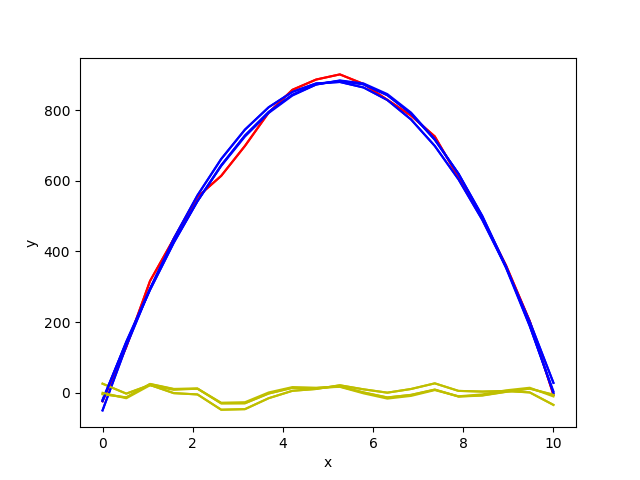

In [44]:
%matplotlib notebook
print(y_fitted(x,c))
import matplotlib.pyplot as plt

fit_y=y_fitted(x,c)
#from pylab import xlabel, ylabel, plot
plt.plot(x,y,'r')
plt.plot(x,fit_y,'b')
plt.plot(x,y-fit_y,'y')
plt.xlabel('x')
plt.ylabel('y')
#plt.show()


▶ **CHECKPOINT 2**

We now need some measure of how good the fit is. One such measure is the *reduced chi-squared*, which is simply the sum of the squared residuals divided by the number of *degrees of freedom* – that is, the number of parameters we have fitted:

$$
\chi^2_\text{red} = \frac{\sum_i(y_\text{fitted} - y_\text{observed})^2}{k + 1}.
$$

**Write a function `chi_squared(x, y, coefficients)` to calculate the reduced chi-squared. Evaluate this for your quadratic fit.** 

*Hint:* if you can, try to make your function independent of the number of coefficients so that you can reuse it for a fit that is not quadratic. The denominator $k+1$ is the size of `coefficients`: use `coefficients.size` or `len(coefficients)`.

In [45]:
def chi_squared(x, y, coefficients):
    """Documentation string here."""
    Size=coefficients.size
    return sum((y_fitted(x,coefficients)-y)**2)/(Size)

    

In [47]:
chi_squared(x, y,c)

2872.5969514796543

**Try higher-order fits (cubic, quartic, …). How does the $\chi^2$ value change?**

▶ **CHECKPOINT 3**

<IPython.core.display.Javascript object>


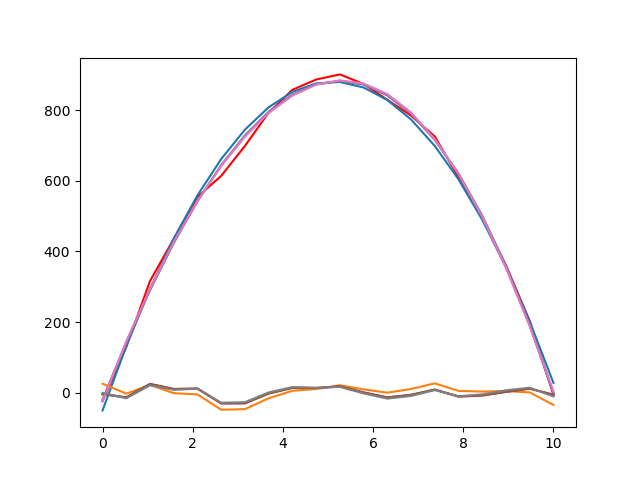

0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5


In [50]:
%matplotlib notebook
plt.plot(x,y,'r')
for magnitude in range(2,6):
    coefficients=np.linalg.solve(coefficient_matrix(x, magnitude),constant_matrix(x, y, magnitude))
    fit_y=y_fitted(x,coefficients)
    plt.plot(x,fit_y)
    plt.plot(x,y-fit_y)